Vendor scorecard saved as vendor_scorecard.csv
                 vendor_id  avg_views  posts_per_week  avg_price  \
0              @Shewabrand      100.0            7.50        NaN   
1            @ZemenExpress      100.0           12.43    1037.79   
2  @ethio_brand_collection      100.0            8.49    3728.43   
3       @meneshayeofficial      100.0            4.84    5475.00   
4            @nevacomputer      100.0            1.11   76508.79   

   lending_score                                        top_product  top_price  
0          53.75  Bale sta Size 40 MADE IN VIETNAM original SHEW...        NaN  
1          56.21  Food mould Tool ስድስት አይነት ቅርጽ ዋጋ 700 ብር ውስን ፍሬ...      700.0  
2          54.25  Puma beige SD Size 394041424344 Price 3700 bir...     3700.0  
3          52.42  የእርስዎ ትዝታ ፤የልጆዎ ጨዋታ ዘምኖ መጣ የያኔው እቃቃ ልክ እንደ እውነ...        NaN  
4          50.56  Dell Precision Workstation A powerful performa...        NaN  


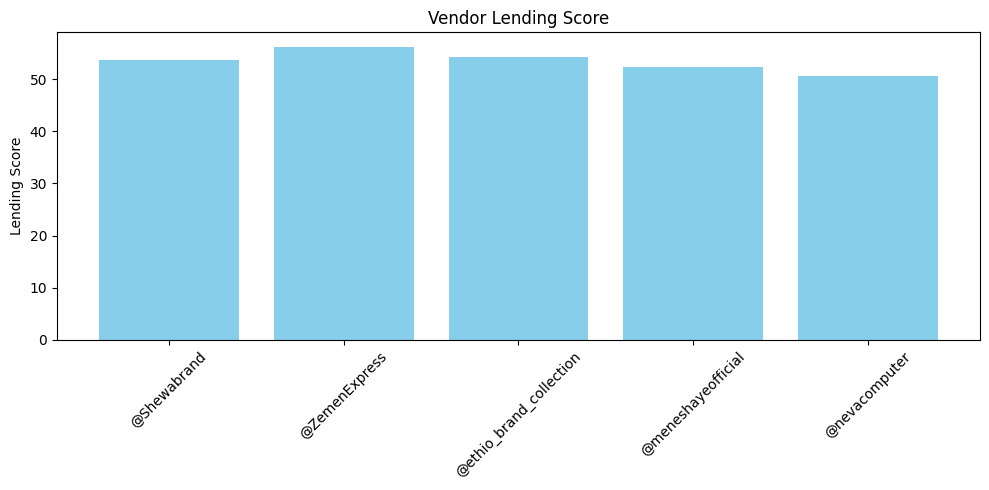

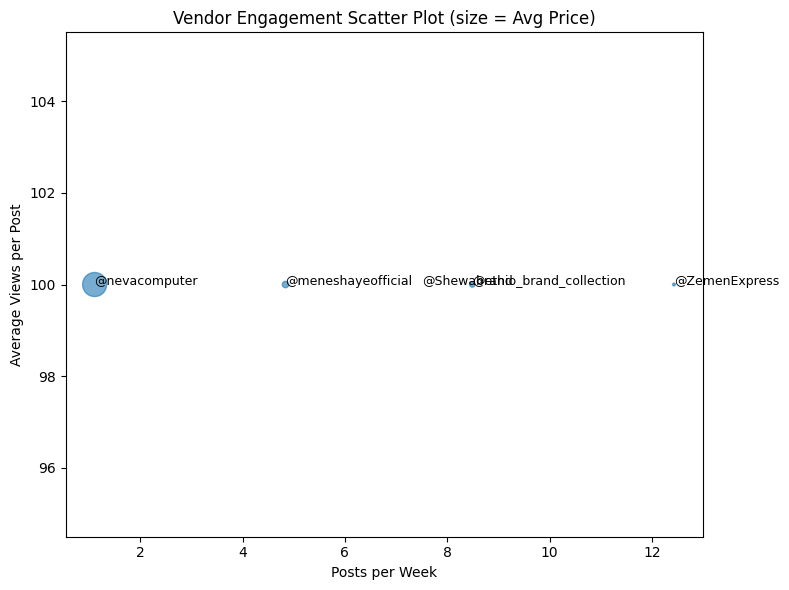

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# -----------------------------
# 1️⃣ Load & Prepare Data
# -----------------------------
df_raw = pd.read_csv("amharic_telegram_cleaned_data.csv")

# Keep relevant columns
df_posts = df_raw[['channel', 'timestamp', 'cleaned_text', 'prices']].copy()
df_posts.rename(columns={'channel': 'vendor_id', 'cleaned_text': 'post_text', 'prices': 'price'}, inplace=True)

# Convert price to numeric
def extract_price(price_text):
    if pd.isna(price_text):
        return None
    match = re.findall(r'\d+', str(price_text))
    return float(match[0]) if match else None

df_posts['price'] = df_posts['price'].apply(extract_price)

# Convert timestamp
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'])

# Placeholder for views if missing
if 'views' not in df_posts.columns:
    df_posts['views'] = 100

# -----------------------------
# 2️⃣ Load NER Model
# -----------------------------
model_name = "./amharic_ner_model_final"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
label_list = model.config.id2label  # mapping from IDs to NER labels

# -----------------------------
# 3️⃣ Define NER Extraction
# -----------------------------
def extract_product(text):
    if not isinstance(text, str):
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    product_tokens = []
    current_product = []
    
    for token, pred in zip(tokens, predictions[0]):
        label = label_list[int(pred)]
        if label.endswith("PRODUCT"):
            current_product.append(token.replace("##", ""))
        else:
            if current_product:
                product_tokens.append(" ".join(current_product))
                current_product = []
    if current_product:
        product_tokens.append(" ".join(current_product))
    
    return ", ".join(product_tokens) if product_tokens else None

# Apply NER to get products
df_posts['product'] = df_posts['post_text'].apply(extract_product)

# -----------------------------
# 4️⃣ Compute Vendor Metrics
# -----------------------------
vendor_metrics = []

for vendor, group in df_posts.groupby('vendor_id'):
    weeks = (group['timestamp'].max() - group['timestamp'].min()).days / 7
    posts_per_week = len(group) / weeks if weeks > 0 else len(group)
    
    avg_views = group['views'].mean()
    avg_price = group['price'].mean()
    
    top_idx = group['views'].idxmax()
    top_product = group.loc[top_idx, 'product'] if group.loc[top_idx, 'product'] else group.loc[top_idx, 'post_text'][:50]+"..."
    top_price = group.loc[top_idx, 'price']
    
    lending_score = 0.5 * avg_views + 0.5 * posts_per_week
    
    vendor_metrics.append({
        'vendor_id': vendor,
        'avg_views': round(avg_views, 2),
        'posts_per_week': round(posts_per_week, 2),
        'avg_price': round(avg_price, 2) if avg_price else None,
        'lending_score': round(lending_score, 2),
        'top_product': top_product,
        'top_price': top_price
    })

df_vendor_scorecard = pd.DataFrame(vendor_metrics)

# -----------------------------
# 5️⃣ Save Scorecard
# -----------------------------
df_vendor_scorecard.to_csv("vendor_scorecard.csv", index=False, encoding='utf-8-sig')
print("Vendor scorecard saved as vendor_scorecard.csv")
print(df_vendor_scorecard)

# -----------------------------
# 6️⃣ Visualizations
# -----------------------------
# Bar chart: Lending Score per vendor
plt.figure(figsize=(10, 5))
plt.bar(df_vendor_scorecard['vendor_id'], df_vendor_scorecard['lending_score'], color='skyblue')
plt.ylabel("Lending Score")
plt.title("Vendor Lending Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("vendor_lending_score.png", dpi=300)
plt.show()

# Scatter plot: Avg Views vs Posts/Week (size = Avg Price)
plt.figure(figsize=(8, 6))
sizes = df_vendor_scorecard['avg_price'].fillna(0) / df_vendor_scorecard['avg_price'].max() * 300
plt.scatter(df_vendor_scorecard['posts_per_week'], df_vendor_scorecard['avg_views'], s=sizes, alpha=0.6)
for i, row in df_vendor_scorecard.iterrows():
    plt.text(row['posts_per_week'], row['avg_views'], row['vendor_id'], fontsize=9)
plt.xlabel("Posts per Week")
plt.ylabel("Average Views per Post")
plt.title("Vendor Engagement Scatter Plot (size = Avg Price)")
plt.tight_layout()
plt.savefig("vendor_engagement_scatter.png", dpi=300)
plt.show()
